# 电力行业碳排放量预测模型

本项目使用XGBoost算法预测电力企业碳排放量，通过SF6排放和输配电损失两个关键特征进行建模。

In [ ]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import re
import warnings
import ipywidgets as widgets
from IPython.display import display

# 导入utils.py中的函数
import sys

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

sys.path.append("..")
from utils import PowerIndustryEmissions

# 忽略警告信息
warnings.filterwarnings("ignore")

## 1. 数据加载与预处理

In [3]:
# 读取数据
file_path = "./datasets/电力行业.csv"
df = pd.read_csv(file_path)

# 显示前几行数据
df.head()

,企业,年份,退役设备SF6容量,修理设备SF6容量,退役设备SF6回收量,修理设备SF6回收量,退役设备数量,修理设备数量,供电量,售电量,区域电网排放因子,碳排放量
0,华电集团-山东分公司,2020,"2,800","1,200","2,520","1,080",9,6,"1,050,000","997,500",0.78,"358,050"
1,国电投-江苏风电场,2021,"1,500",800,"1,350",720,5,4,"320,000","304,000",0.72,"89,400"
2,中广核-广东核电基地,2022,"4,200","1,800","3,780","1,620",14,9,"2,800,000","2,660,000",0.62,"654,840"
3,华润电力-华中分部,2023,"3,600","1,500","3,420","1,425",12,7,"1,800,000","1,710,000",0.7,"357,525"
4,中国电建-西北项目,2024,"5,500","2,200","5,225","2,090",18,11,"4,200,000","3,990,000",0.8,"1,614,250"


In [4]:
# 检查数据基本情况
print(f"数据集形状: {df.shape}")
df.info()

数据集形状: (120, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   企业          120 non-null    object
 1   年份          120 non-null    int64 
 2   退役设备SF6容量   120 non-null    object
 3   修理设备SF6容量   120 non-null    object
 4   退役设备SF6回收量  120 non-null    object
 5   修理设备SF6回收量  120 non-null    object
 6   退役设备数量      120 non-null    int64 
 7   修理设备数量      120 non-null    int64 
 8   供电量         120 non-null    object
 9   售电量         120 non-null    object
 10  区域电网排放因子    120 non-null    object
 11  碳排放量        120 non-null    object
dtypes: int64(3), object(9)
memory usage: 11.4+ KB


In [5]:
# 处理数值型数据中的逗号和括号
def clean_numeric(x):
    if isinstance(x, str):
        # 移除逗号
        x = x.replace(",", "")
        # 如果有百分比注释，提取数值部分
        match = re.search(r"([\d.]+)\s*\(\d+%\)", x)
        if match:
            return float(match.group(1))
        # 检查是否包含其他括号注释
        match = re.search(r"([\d.]+)\s*\(", x)
        if match:
            return float(match.group(1))
        return float(x)
    return x


# 应用清洗函数到所有可能的数值列
numeric_columns = [
    "退役设备SF6容量",
    "修理设备SF6容量",
    "退役设备SF6回收量",
    "修理设备SF6回收量",
    "退役设备数量",
    "修理设备数量",
    "供电量",
    "售电量",
    "区域电网排放因子",
    "碳排放量",
]

for col in numeric_columns:
    df[col] = df[col].apply(clean_numeric)

In [6]:
# 检查数据清洗后的情况
df.describe()

,年份,退役设备SF6容量,修理设备SF6容量,退役设备SF6回收量,修理设备SF6回收量,退役设备数量,修理设备数量,供电量,售电量,区域电网排放因子,碳排放量
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,1.200000e+02,120.000000,1.200000e+02
mean,2022.225000,2382.083333,964.333333,2246.715833,909.134167,8.233333,5.150000,6.672917e+06,6.339271e+06,0.692500,1.067105e+06
std,1.682647,1485.624615,603.357181,1404.858105,569.622188,4.797992,2.761226,7.318771e+06,6.952833e+06,0.110433,1.706187e+06
min,2020.000000,600.000000,250.000000,540.000000,225.000000,3.000000,2.000000,2.800000e+05,2.660000e+05,0.480000,8.360000e+04
25%,2021.000000,1100.000000,450.000000,1067.000000,434.250000,4.000000,3.000000,1.675000e+06,1.591250e+06,0.600000,1.813500e+05
50%,2022.000000,1900.000000,750.000000,1773.000000,720.000000,7.000000,4.000000,3.550000e+06,3.372500e+06,0.700000,3.500875e+05
75%,2024.000000,3500.000000,1425.000000,3342.500000,1352.000000,12.000000,7.000000,8.750000e+06,8.312500e+06,0.800000,1.051875e+06
max,2025.000000,6000.000000,2500.000000,5700.000000,2375.000000,20.000000,12.000000,3.200000e+07,3.040000e+07,0.920000,6.612500e+06


## 2. 特征工程 - 调用utils.py中的函数

In [7]:
# 计算SF6排放量
df["sf6_emission"] = df.apply(
    lambda row: PowerIndustryEmissions.calculate_sf6_emission(
        row["退役设备SF6容量"],
        row["修理设备SF6容量"],
        row["退役设备SF6回收量"],
        row["修理设备SF6回收量"],
        row["退役设备数量"],
        row["修理设备数量"],
    ),
    axis=1,
)

# 计算输配电损失排放
df["transmission_loss_emission"] = df.apply(
    lambda row: PowerIndustryEmissions.calculate_transmission_loss_emission(
        row["供电量"], row["售电量"], row["区域电网排放因子"]
    ),
    axis=1,
)

# 查看新增特征
df[["sf6_emission", "transmission_loss_emission"]].describe()

,sf6_emission,transmission_loss_emission
count,1.200000e+02,120.000000
mean,5.958449e+07,226787.208333
std,7.163249e+07,241405.883157
min,2.588370e+06,9520.000000
25%,8.227575e+06,57875.000000
50%,2.061375e+07,121725.000000
75%,8.688248e+07,312625.000000
max,2.645730e+08,902000.000000


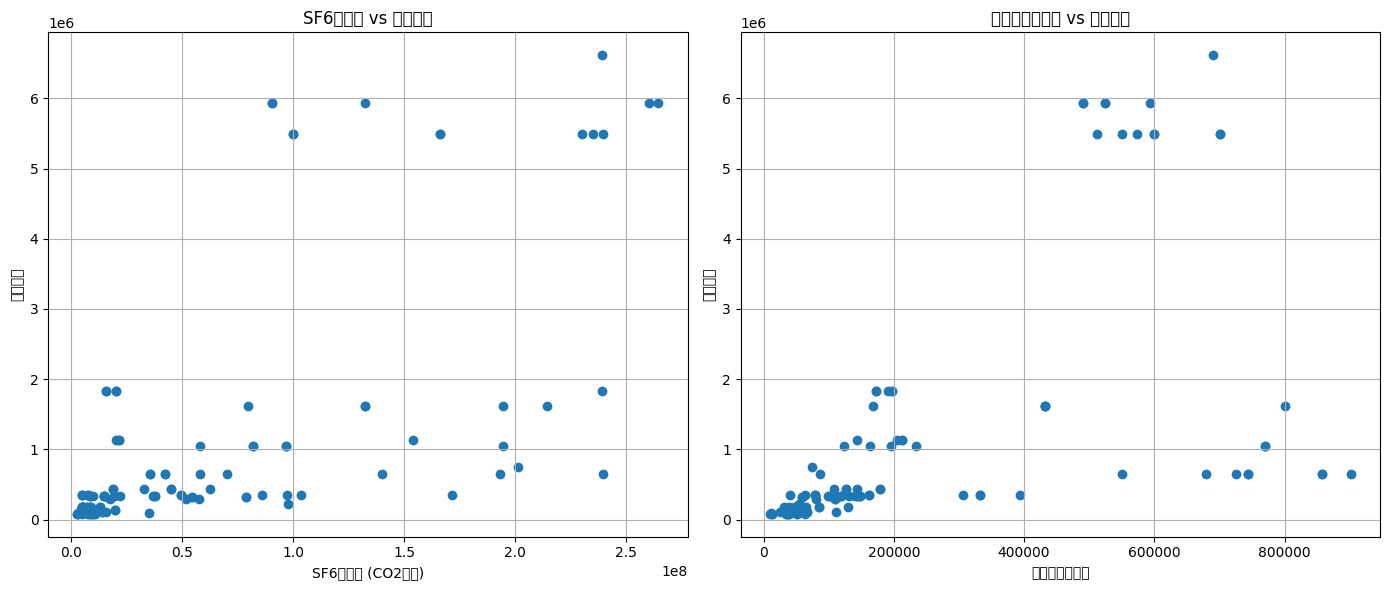

In [8]:
# 绘制特征与目标变量的关系
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(df["sf6_emission"], df["碳排放量"])
plt.title("SF6排放量 vs 碳排放量")
plt.xlabel("SF6排放量 (CO2当量)")
plt.ylabel("碳排放量")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(df["transmission_loss_emission"], df["碳排放量"])
plt.title("输配电损失排放 vs 碳排放量")
plt.xlabel("输配电损失排放")
plt.ylabel("碳排放量")
plt.grid(True)

plt.tight_layout()
plt.show()

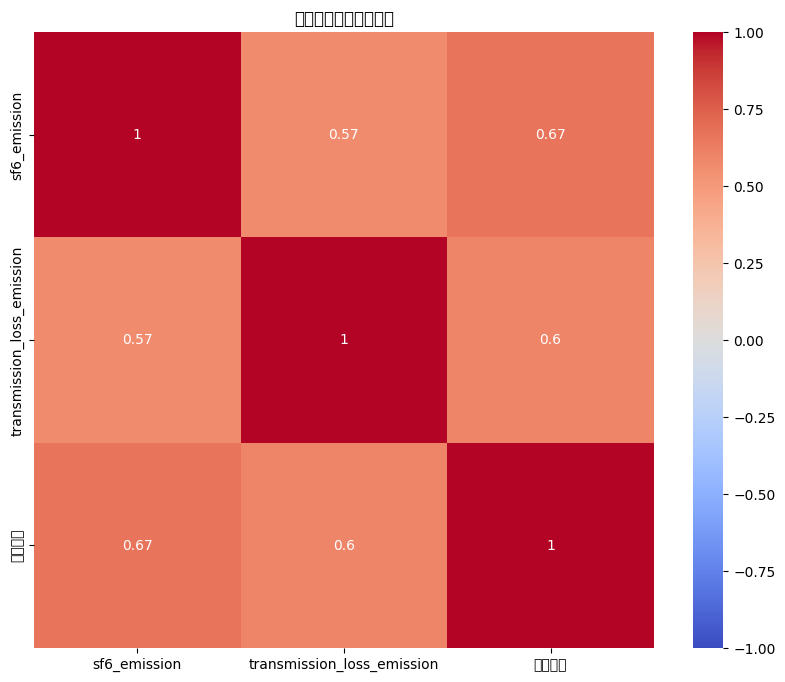

In [9]:
# 计算相关系数
correlation = df[["sf6_emission", "transmission_loss_emission", "碳排放量"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("特征与目标变量相关性")
plt.show()

## 3. 构建XGBoost模型

In [10]:
# 准备特征和目标变量
X = df[["sf6_emission", "transmission_loss_emission"]]
y = df["碳排放量"]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
# 定义初始XGBoost模型
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# 训练模型
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"均方误差 (MSE): {mse:.2f}")
print(f"均方根误差 (RMSE): {rmse:.2f}")
print(f"决定系数 (R²): {r2:.4f}")
print(f"平均绝对误差 (MAE): {mae:.2f}")

均方误差 (MSE): 289371821933.97
均方根误差 (RMSE): 537932.92
决定系数 (R²): 0.8881
平均绝对误差 (MAE): 304555.67


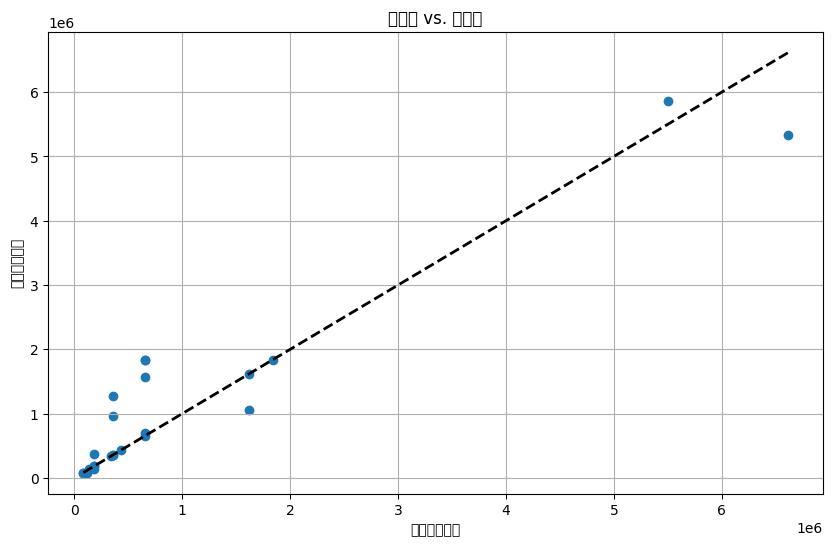

In [12]:
# 预测值与实际值比较
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("实际碳排放量")
plt.ylabel("预测碳排放量")
plt.title("预测值 vs. 实际值")
plt.grid(True)
plt.show()

## 6. 创建交互式预测界面

In [13]:
def predict_emission(
    retired_equipment_sf6_capacity,
    repaired_equipment_sf6_capacity,
    retired_equipment_sf6_recovery,
    repaired_equipment_sf6_recovery,
    retired_equipment_num,
    repaired_equipment_num,
    supply_electricity,
    sold_electricity,
    regional_grid_emission_factor,
):
    # 计算SF6排放量
    sf6_emission = PowerIndustryEmissions.calculate_sf6_emission(
        retired_equipment_sf6_capacity,
        repaired_equipment_sf6_capacity,
        retired_equipment_sf6_recovery,
        repaired_equipment_sf6_recovery,
        retired_equipment_num,
        repaired_equipment_num,
    )

    # 计算输配电损失排放
    transmission_loss_emission = (
        PowerIndustryEmissions.calculate_transmission_loss_emission(
            supply_electricity, sold_electricity, regional_grid_emission_factor
        )
    )

    # 创建特征数据
    features = np.array([[sf6_emission, transmission_loss_emission]])

    # 预测
    prediction = model.predict(features)[0]

    return sf6_emission, transmission_loss_emission, prediction

In [ ]:
# 创建交互式GUI
style = {"description_width": "180px"}
layout = widgets.Layout(width="500px")

retired_equipment_sf6_capacity = widgets.FloatText(
    description="退役设备SF6容量:", style=style, layout=layout, value=3000.0
)

repaired_equipment_sf6_capacity = widgets.FloatText(
    description="修理设备SF6容量:", style=style, layout=layout, value=1200.0
)

retired_equipment_sf6_recovery = widgets.FloatText(
    description="退役设备SF6回收量:", style=style, layout=layout, value=2700.0
)

repaired_equipment_sf6_recovery = widgets.FloatText(
    description="修理设备SF6回收量:", style=style, layout=layout, value=1080.0
)

retired_equipment_num = widgets.IntText(
    description="退役设备数量:", style=style, layout=layout, value=10
)

repaired_equipment_num = widgets.IntText(
    description="修理设备数量:", style=style, layout=layout, value=6
)

supply_electricity = widgets.FloatText(
    description="供电量(kWh):", style=style, layout=layout, value=5000000.0
)

sold_electricity = widgets.FloatText(
    description="售电量(kWh):", style=style, layout=layout, value=4750000.0
)

regional_grid_emission_factor = widgets.FloatText(
    description="区域电网排放因子:", style=style, layout=layout, value=0.7
)

output = widgets.Output()


def on_button_clicked(b):
    with output:
        output.clear_output()
        sf6_emission, transmission_loss, prediction = predict_emission(
            retired_equipment_sf6_capacity.value,
            repaired_equipment_sf6_capacity.value,
            retired_equipment_sf6_recovery.value,
            repaired_equipment_sf6_recovery.value,
            retired_equipment_num.value,
            repaired_equipment_num.value,
            supply_electricity.value,
            sold_electricity.value,
            regional_grid_emission_factor.value,
        )
        print(f"特征计算结果:")
        print(f"SF6排放量: {sf6_emission:.2f} CO2当量")
        print(f"输配电损失排放: {transmission_loss:.2f}")
        print(f"\n预测的碳排放量: {prediction:.2f}")


button = widgets.Button(description="预测碳排放量")
button.on_click(on_button_clicked)

# 显示GUI
input_widgets = [
    retired_equipment_sf6_capacity,
    repaired_equipment_sf6_capacity,
    retired_equipment_sf6_recovery,
    repaired_equipment_sf6_recovery,
    retired_equipment_num,
    repaired_equipment_num,
    supply_electricity,
    sold_electricity,
    regional_grid_emission_factor,
]

display(widgets.VBox(input_widgets + [button, output]))